# Proyecto Final Analisis y Diseno de Algortimos
## Jonathan Valencia

 
## Conversion de figuras geometricas en imagenes 2D a un modelo 3D


OpenCV (pip install opencv-contrib-python) es una libreria enfocada en problemas de vision artificial, critica para nuestro proyecto por su modulo de procesamiento de imagenes geometricas.


La funcion de dimensionamiento requiere de 3 vistas de la figura (frente,lateral y superior) y nos permitira deliniear las imagenes en sus bordes. Y posteriormente nos permitira mutiplicar el valor del radio con estas lineas de contorno para tener la longitud total.

In [70]:
import time
import os
import shutil
##############
import cv2
##############
import numpy as np
from IPython.display import Image
from utils.tree import createtree
from utils.operation import *


def Dimensioning(userId,view,image):

    #Carpeta temporal para guardar las imagenes con contornos
    os.makedirs('static/temp', exist_ok=True)
    #leemos la imagen
    img = cv2.imread(image,cv2.IMREAD_UNCHANGED)
    #Inicializacion 
    ratio = 0
    shape = "unidentified"
    #Getting the size of image
    try:
        w,h,_=img.shape
        drawSize = int(h/300)
        #si se requiere y la imagen esta en color se convierte a escala de grises
        imgrey = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
        #Y luego a binario
        ret, thresh = cv2.threshold(imgrey,127,255,cv2.THRESH_BINARY_INV)
        #Encotramos los contornos
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
        #sort de los contornos de area para identificar el contorno mas grande
        hierarchy,contours = zip(*sorted(zip(hierarchy[0],contours),key = lambda x: cv2.contourArea(x[1]),reverse=True))

        for i,c in enumerate(contours):
            #usamos el contorno mas grande
            if(hierarchy[i][3] != -1  or (hierarchy[i][3] == -1 and hierarchy[i][2] == -1) ):
                M = cv2.moments(c)
                if(M["m00"] !=0):
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    #obtener el area minima del contorno
                    rect = cv2.minAreaRect(c)
                    box = cv2.boxPoints(rect)
                    box = np.int0(box)
                    x,y,w,h = cv2.boundingRect(c)
                    #detectar formas
                    shape, cylinder_type = detect(c)              
                    if(shape == "unidentified"):
                        continue

                    if(shape=="triangle" or shape=="pentagon" or shape=="hexagon"):
                        img = cv2.drawContours(img, [box], 0, (0,0, 255), drawSize)
                    # w ancho del rectangulo rodeando el circulo
                    if(shape=="circle"):
                        # remarcar contornos
                        img = cv2.rectangle(img,(x,y),(x+w,y+h),(0, 0, 255),drawSize)
                        cv2.line(img, (x,y), (x+w,y), (0,255, 0), 2)
                        ratio = 1/w
                    else:
                        
                        cv2.line(img, tuple(box[0]), tuple(box[1]), (0,255, 0), 2)
                        #Largo por pixel
                        ratio = 1.0/rect[1][1]
                    break

        #guardar imagen con contornos
        folder = 'static/temp/' + userId
        os.makedirs(folder, exist_ok=True)
        #si el archivo existe se elimina
        try:
            os.remove(folder + '/' + view + '.jpg')
        except: pass

        path_file = (folder + '/' + view + '.jpg')

        #reducir tamaño de imagen
        small = cv2.resize(img, (0,0), fx=0.5, fy=0.5) 
        cv2.imwrite(path_file,small)
        #Convertir a string
        ratio = str(ratio)
        #guardar datos en archivo
        data={'image': path_file,'shape': shape,'ratio': ratio}
        display(Image(filename = path_file))
        return data
    except:
      print(view + "image not found")

## Funcion de Conversion
Una vez que tenemos las 3 imagenes y la longitud, procedemos a crear el modelo 3D

In [71]:
def Convert(userId, front_image, side_image, top_image, fratio, sratio, tratio):
    # comienza cronometro 
    start = time.time() 
    os.makedirs('static/'+userId, exist_ok=True)

    img_front = cv2.imread(front_image,cv2.IMREAD_UNCHANGED)
    img_side = cv2.imread(side_image,cv2.IMREAD_UNCHANGED)
    img_top = cv2.imread(top_image,cv2.IMREAD_UNCHANGED)

    fratio = float(fratio)
    sratio = float(sratio)
    tratio = float(tratio)
    filePath = "static/temp/"+userId
#Remover archivos temporales
    try:
        shutil.rmtree(filePath)
    except OSError as e:
        print ("Error: %s - %s." % (e.filename, e.strerror))

    primitive = []
    #front
    object_front = valid_contours(img_front,"front",fratio)
    re_arrange(object_front,"front")
    
    #side
    object_side = valid_contours(img_side,"side",sratio)
    re_arrange(object_side,"side")

    #Top
    object_top = valid_contours(img_top,"top",tratio)
    re_arrange(object_top,"top")

    #umbral de error        
#     minApprox = 4 * max(fratio,sratio,tratio)
    minApprox = 0.05
    primitive = combining(object_front,object_side,object_top,minApprox)
    final = []
    for set in primitive:
        for shape in set:
            final.append(shape[0])
    
    #si el archivo existe se elimina
    try:
        os.remove('static/' + userId + "/" + userId + '.scad')
    except: pass

    #Generar archivo .scad
    path_file = ('static/' + userId + "/" + userId + '.scad')
    #si la lista esta vacia se genera una ecepcion
    if(len(final) == 0):
        path_file = 'static/error.txt'
        f = open(path_file, "w")
        f.write("No se pudo determinar la geometria del objetco, intenta otra figura!")
        f.close()
    createtree(final,path_file)
    # fin del cronometro 
    end = time.time() 
    print("Tiempo total:",end-start)
    return path_file


## Ejecucion
Comenzamos leyendo las 3 imagenes del repositorio:

In [72]:
userId="random"
front_image = "Repository/"+userId+"/front.jpg"
side_image = "Repository/"+userId+"/side.jpg"
top_image = "Repository/"+userId+"/top.jpg"
front_image

'Repository/random/front.jpg'

Se usa el dimensionamiento en la vista frontal

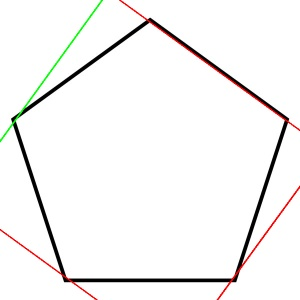

{'image': 'static/temp/random/front.jpg',
 'shape': 'pentagon',
 'ratio': '0.0019478109358456418'}

In [73]:
d1 = Dimensioning(userId,"front",front_image)
d1

Vista lateral:


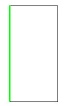

{'image': 'static/temp/random/side.jpg',
 'shape': 'rectangle',
 'ratio': '0.0052083341611757535'}

In [74]:
d2 = Dimensioning(userId,"side",side_image)
d2

Vista superior:

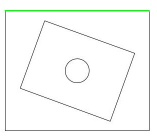

{'image': 'static/temp/random/top.jpg',
 'shape': 'rectangle',
 'ratio': '0.003472222222222222'}

In [75]:
d3 = Dimensioning(userId,"top",top_image)
d3

Despues tenemos que multiplicar los radios extraidos de la funcion de dimension con las longitudes fijas
Esto permite respeta el pixel:dimension para que no varie con los pixeles de las imagenes


In [76]:

fratio = float(d1["ratio"]) * 2 #ancho del regangulo para frontal
sratio = float(d2["ratio"]) * 3 
tratio = float(d3["ratio"]) * 1.73 

Finalmente, llamamos a la funcion convert para generar el modelo 3D scad model y su path

In [77]:
Convert(userId,front_image, side_image, top_image,fratio, sratio, tratio)

Subtree: 2
Tiempo total: 0.016984939575195312


'static/random/random.scad'